# Hartree Fock Approximation. 

### Structure of notebook

1. Parameters of the cattering region are defined.
2. Parameters of the fermi dirac function & Integration interval are defined.
3. Electron Density is self-consistently calculated
4. The magnetocurrent $\Delta I(m,V) = I(m) - I(-m)$ is calculated.
5. P value is calculated

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Path to modules

In [2]:
import sys
sys.path.insert(0, '/Users/khhuisman/Documents/Jupyter_notebooks/Coulomb_Paper3_PHS_Collinear/Modules_Coulomb_Github')

# sys.path.insert(0, '<path_to_modules>')

## Scattering Region

In [3]:
import Sgeom_scatteringregion as Sgeom

## Functions for electron density

In [4]:
import handy_functions_coulomb as hfc
import Integration_HFA as Integration_method
import Currents_HF_git as Current_method
import Pvalue

In [5]:
import negf_git as negf_method

# Energies to integrate over, Fermi Energy

In [6]:
def plot_densities(nP_list_conv,nM_list_conv,V_list_convg,Hamiltonian0):
    dimlist = hfc.func_list_i(Hamiltonian0)
    plt.title('$n_{is}(m,V) - n_{i\overline{s}}(-m,V)$')
    n_list_total_convgM_swap = [hfc.pairwise_swap([ nM_list_conv[i][k] for k in dimlist]) for i in range(len(V_list_convg))
                              ]
    nP_list_plot =[ [nP_list_conv[i][k] for k in dimlist ] for i in range(len(V_list_convg)) ]


    plt.plot(V_list_convg,np.subtract(nP_list_plot,n_list_total_convgM_swap))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()
    
    
def plot_densities_symmtry_relation(nP_list,nM_list,V_list,dim):
    
    '''
    Input:
        - nP_list,nM_list = electron densities as function of voltages for positive,negative magnetization
        - V_list = list of voltages
        - dim = total number of electron densities
        
    Ouput:
        Plot of "n_{is}(m,V) + n_{i\overline{s}}(-m,-V) - 1" as function of voltage
        this quantity should be zero (within numerical accuracy of integral & tol) 
    '''
    
    dimlist = [i for i in range(dim)]
    ones = [1 for i in range(dim)]
    n_list_swapM = [np.subtract(ones,hfc.pairwise_swap(nM_list[-1-i])) for i in range(len(nM_list))]
    nP_list_plot =[ [nP_list[i][k] for k in dimlist ] for i in range(len(V_list)) ]

    plt.title('$n_{is}(m,V) + n_{i\overline{s}}(-m,-V) - 1$')
    plt.plot(V_list,np.subtract(nP_list_plot,n_list_swapM))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()

In [7]:
# def func_energies(Hamiltonian0,U,npoints,npoints_tail):
#     '''
#     Input:
#     Hamiltonian0 = molecule without interaction (U=0)
#     U = interaction strength
#     npoints = number of energy points in window [emin,emax]
#     Output:
#     emax = upper bound of intergral
#     emin = lowest eigenvalue of Hamiltonian0
#     energiesreal = list of energies between [emin-1000,emax] (make sure the emax < ef +Vmax/2)
#     eflist = list of fermi energies for which to calculate electron densities.
#     '''
#     evlist = np.linalg.eigh(Hamiltonian0)[0]
#     e_lumo = evlist[int(Hamiltonian0.shape[0]/2)-1]
#     e_homo = evlist[int(Hamiltonian0.shape[0]/2)]
#     #Fermi Energy
#     hl_gap = e_lumo - e_homo
    
    
    
#     #lower,upper bound for Glesser function
#     emin = np.round(int(10*min(evlist))/10 - 10,2) #lower bound for integrals
#     emax = np.round(int(10*max(evlist))/10 + 10,2)   #lower bound for integrals
    
    
#     energies_zero4000 = np.linspace(emin-5000,emin,npoints_tail) #In wide band limit the integrand has a long "tail"
   
#     energiesreal_prime = np.linspace(emin,emax,npoints)
    
#     energiesreal = np.unique(hfc.jointwolist(energies_zero4000,energiesreal_prime))
    
    
#     ### Note to user: The symmetric point mentioned in paper is not EF = U/2 but EF = 0 in this case,because
#     ### the energies of the Green's function are shifted as: G+(E) -> G+(E + U/2).
#     eflist = [ abs(np.round( 0  + kappa*hl_gap/2,2)) for kappa in [0.0] ]
    

    
#     return emin,emax,npoints,energiesreal,eflist

def func_energies(Hamiltonian0,n00listguess,
                   GammaL,GammaR,U,npoints,npoints_tail,
                   ef,T,Vmax,tol_nintegrand):
    '''
    Input:
    Hamiltonian0 = Hamiltonian of the isolated molecule without interactions (U=0)
    U            = interaction strength
    npoints      = number of energy points in window [emin,emax]
    npointstail = number of energy points in window [emin2,emin)
    Output:
        energiesreal = list of energies to calculate the Glesser integral with.
        emax = upper bound of intergral
        emin = lowest eigenvalue of Hamiltonian0 - 10 eV
        emin2 = lower bound of integral.    
    '''
    
    
    mu_max = ef + Vmax/2            ## largest chemical potential
    beta = negf_method.func_beta(T) ## beta
    
    dim = Hamiltonian0.shape[0]
    
    #Lower bound: 
    ### At lower bound of integral:
    ### <n>  = \int G+ fi Gammai G- dE ~ \int G+ Gammai G- dE
    ### the fermi functions are approximately 1.
    ### The integrand-size is related to the lowest eigenvalue of "Hamiltonian0":
    evlist = np.linalg.eigh(Hamiltonian0)[0]        ##list of eigenvalues
    e_lumo = evlist[int(Hamiltonian0.shape[0]/2)-1] ##lumo energy
    e_homo = evlist[int(Hamiltonian0.shape[0]/2)]   ##homo energy
    hl_gap = e_lumo - e_homo                        ##HL energy
    
    ### Therefore we 'guess' a lowest value:
    emin = np.round(int(10*min(evlist))/10 -10 ,2) 
    
    ### and check if this falls within a tolerance 'tol_nintegrand':
    emin2 = emin - 20
    boundbool = False
    HamiltonianU = negf_method.Hamiltonian_HF(n00listguess,U,Hamiltonian0)
    print('Estimating lower bound...')
    while boundbool == False:
        
        emin2 = emin2 - 30
        
        
        nlist_min    =  [ negf_method.ndensity_listi(emin2,
                                                     HamiltonianU,
                                                     GammaL,GammaR,
                                                    ef, ef,
                                                    betaL,betaR)[i] for i in range(dim)]

        check_zerob, boundbool = hfc.check_listzero(nlist_min,tol_nintegrand)
#         print(emin2,check_zerob,boundbool)
    
  
    
    
    ### Upper Bound:
    ### Due to fermi dirac function, the integrand of <n>:
    ### <n> = \int G+ fi Gammai G- dE ~ \int fi dE 
    ### will fall off quickly to zero near the energy ef + V/2
    ### Therefore the largest energy we need to consider is close to ef + Vmax/2:
    
    emax = mu_max #intial guess emax
    fmax = negf_method.fermi_dirac(emax,mu_max,beta) #intial guess efmax
    
    
    ### We continue our search iteratively
    while fmax >= tol_nintegrand/1000:
        emax = np.round(emax + 0.5,2)
        fmax = negf_method.fermi_dirac(emax,mu_max,beta)
    
    
    
    
    energies_tail = np.linspace(emin2,emin,npoints_tail)  #In wide band limit the integrand has a long "tail"
    energiesreal_prime = np.linspace( emin, emax,npoints) 
    energiesreal = np.unique(hfc.jointwolist(energies_tail,energiesreal_prime))
   
    return emin2,emin,emax,npoints,energiesreal


## Define Scattering Region

Hamiltonian0:
- Without Coulomb interactions 
- Not attached to leads.

In [8]:
Lm = 2             #number of sites 
Wg = 2
kmax = 4

epsilon = 0 # onsite energy
t = 2.4     # hopping paramter

# List of Spin-Orbit Coupling parameter
lambdalist = [
            (1*(10**-1))*t
#             ,(1*(10**-3))*t
            ]
# List of interaction strength
Ulist = [ 
       
        1*t
        ] 


#Gamma Matrix
gammaL = 0.5    # coupling strength
pz    = 0.5    # magnetic polarization

pz_P = abs(pz)
pz_M = -abs(pz)


T = 300 # Kelvin Temperature of leads
betaL,betaR = negf_method.func_beta(T), negf_method.func_beta(T) # 1/ElectronVolt
lambda1 = lambdalist[0]



# Bias window

In [12]:
Vmax = 0 # Maximum bias voltage [eV]
dV   = 0.1 # stepsize
V_list_pos_bias,V_list = hfc.func_V_total(Vmax,dV)
print(V_list_pos_bias,V_list
     )

[] [0]


# Self-Consistent criteria & Integration

Comment on the convergence: Hartree Fock converges well for small U i.e. U<t.

In [17]:
tol                 = 1*10**-4 #tolerance on the electron densities 
tol_nintegrand      = 10**-7   #cut-off for integral over Glesser function
max_iteration       = 900      #maximum number of iterations
npoints             = 10000    #npoints energy point for Glesser integral [emin,emax]
npoints_tail        = 5000    #npoints energy point for Glesser integral [emin2,emin]
alpha               = 0.1      #linear mixing paramters
npoints_current     = 15000    #number of points for Landauer-Büttiker formula


-0.6


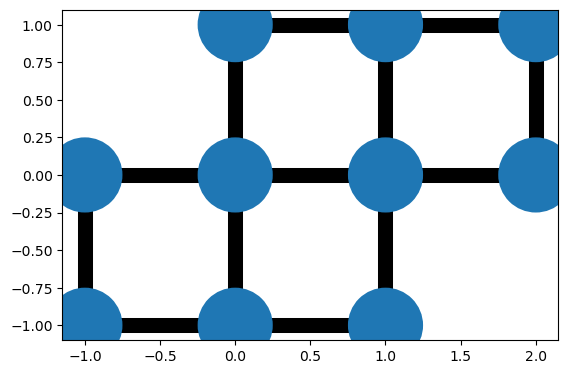

Estimating lower bound...
-1566.8 -16.8 -3.0
ef = -4.0,lambda1/t = 0.1 ,U/t = 1.0
[15000, 2, 2, 4, 0.5, 0.5, 2.0, 300, 0.1, 2.4, 2.4, 0.24, -4.0, 0.0001, 0, 1, -1566.8, -16.8, -3.0, 10000, 5000, 1e-07]


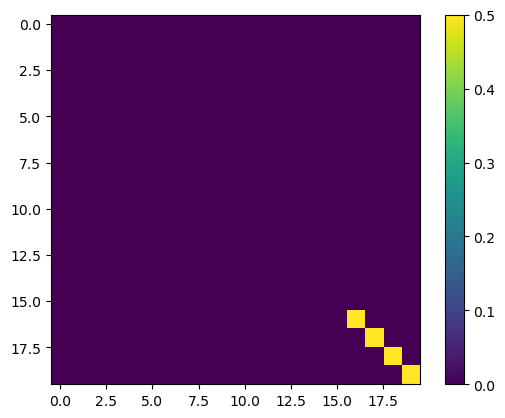

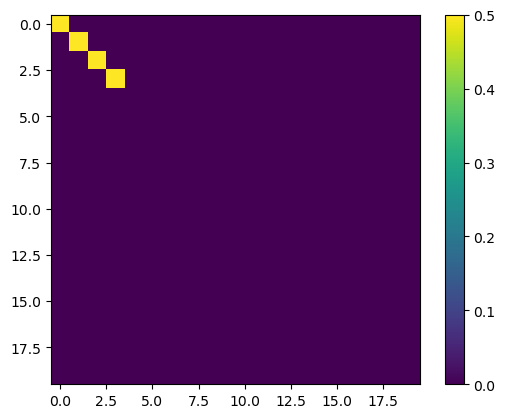

-0.8


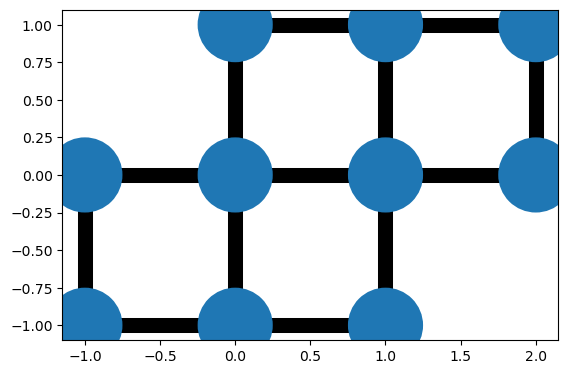

Estimating lower bound...
-1566.8 -16.8 -3.0
ef = -4.0,lambda1/t = 0.1 ,U/t = 1.0
[15000, 2, 2, 4, 0.5, 0.5, 4.5, 300, 0.1, 2.4, 2.4, 0.24, -4.0, 0.0001, 0, 1, -1566.8, -16.8, -3.0, 10000, 5000, 1e-07]


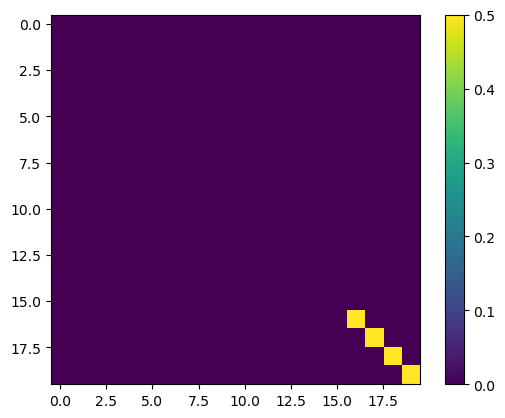

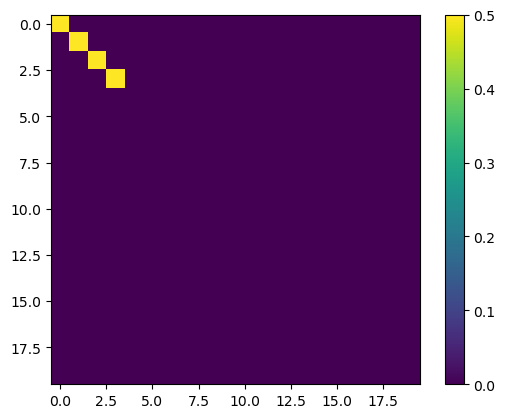

In [18]:
paramlist_tot = []
factorlist = [4,9]
# for U in Ulist:
for factor in factorlist:
    U = Ulist[0]
    gammaR = factor*gammaL
    chi = hfc.func_chi(gammaL,gammaR)
    print(chi)
    Hamiltonian0,GammaR,GammaLP,GammaLM = Sgeom.hamiltonian_multiplesites_coupled_asym(Lm,Wg, t,lambda1,gammaL,gammaL,pz,plotbool=True)




    emin2,emin,emax,npoints,energies = func_energies(Hamiltonian0,hfc.list_halves(Hamiltonian0),
                                                       GammaLP,GammaR,U,npoints,npoints_tail,
                                                       ef,T,Vmax,tol_nintegrand)
    
   
    
    print(emin2,emin,emax)
    print('ef = {},lambda1/t = {} ,U/t = {}'.format(ef,lambda1/t,U/t) )
    
    paramterslist = [npoints_current,Lm,Wg,kmax,pz,gammaL,gammaR,T,alpha,t,U,lambda1,ef,tol, Vmax,len(V_list_total),emin2,emin,emax,npoints,npoints_tail,tol_nintegrand]
    paramlist_tot.append(paramterslist)
    print(paramterslist)
    plt.imshow(GammaR.real)
    plt.colorbar()
    plt.show()
    plt.imshow(0.5*(GammaLP + GammaLM).real)
    plt.colorbar()
    plt.show()

    
        
        
        
        

In [19]:
print(paramlist_tot)

[[15000, 2, 2, 4, 0.5, 0.5, 2.0, 300, 0.1, 2.4, 2.4, 0.24, -4.0, 0.0001, 0, 1, -1566.8, -16.8, -3.0, 10000, 5000, 1e-07], [15000, 2, 2, 4, 0.5, 0.5, 4.5, 300, 0.1, 2.4, 2.4, 0.24, -4.0, 0.0001, 0, 1, -1566.8, -16.8, -3.0, 10000, 5000, 1e-07]]


In [34]:
eflist = np.linspace(-1,1,40)
Vmax = 0
print(U)

2.4


In [35]:
paramlist_tot = []

nlist_total = []

for ef in eflist:
    
    gammaR = gammaL
    
    
    print(gammaR,gammaL)
    
    Hamiltonian0,GammaR,GammaLP,GammaLM = Sgeom.hamiltonian_multiplesites_coupled_asym(Lm,Wg, t,lambda1,gammaL,gammaR,pz,plotbool=False)


    emin2,emin,emax,npoints,energies = func_energies(Hamiltonian0,hfc.list_halves(Hamiltonian0),
                                                       GammaLP,GammaR,U,npoints,npoints_tail,
                                                       ef,T,Vmax,tol_nintegrand)
    print(emin2,emin,emax)




    print('ef = {},lambda1/t = {} ,U/t = {}'.format(ef,lambda1/t,U/t) )
    chi = np.round( (gammaR-gammaL )/(gammaL + gammaR),2).real
    print(gammaL,chi)


    paramterslist = [npoints_current,Lm,Wg,kmax,pz,gammaL,gammaR,T,alpha,t,U,lambda1,ef,tol, Vmax,len(V_list_total),emin2,emin,emax,npoints,npoints_tail,tol_nintegrand]    
    paramlist_tot.append(paramterslist)
    
    n00_list_guess = hfc.list_halves(Hamiltonian0)
    nP_list,convglistP = Integration_method.self_consistent_NR(V_list,
                                  n00_list_guess,
                                  max_iteration,
                                ef,
                                U,
                                Hamiltonian0,
                                GammaLP,GammaR, 
                                betaL, betaR,tol,energies,tol_nintegrand,plotbool=False,trackbool=False)

    nM_list, convglistM = Integration_method.self_consistent_NR(V_list,
                                  hfc.pairwise_swap(nP_list[0]),
                                  max_iteration,
                                ef,
                                U,
                                Hamiltonian0,
                                GammaLM,GammaR, 
                                betaL, betaR,tol,energies,tol_nintegrand,plotbool=False,trackbool=False)
    
    
    nlist_total.append([ nP_list,convglistP,nM_list, convglistM])
 
    

    
path = 'ElecDens_FermiEnergy/'
string = 'Lm{}_Wg{}_kmax{}_pz{}_tcoupLR{}_{}_T{}_alpha{}_t{}_U{}_lambda1{}_tol{}_efmax{}_lenef{}_emin2{}_emin{}_emax{}_npoints{}_ntail{}_tolintegrand{}.txt'.format(Lm,Wg,
                                                                                                                                                                        kmax,pz,gammaL,gammaR,T,
                                                                                                                                                                    alpha,t,
                                                                                                                                                                U,lambda1,tol,
                                                                                                                                                                 max(eflist),
                                                                                                                                                                         len(eflist),
                                                                                                                                                              emin2,emin,emax,npoints,
                                                                                                                                                              npoints_tail,tol_nintegrand)






nPlist_total = []
nMlist_total = []
eflist_adj = []

for k in range(len(eflist)):
    nP_list,convglistP,nM_list, convglistM = nlist_total[k]
    print(sum(nP_list[0]))
    if convglistP[0] == True and convglistM[0] == True:
        nPlist_total.append(sum(nP_list[0]))
        nMlist_total.append(sum(nM_list[0]))
        eflist_adj.append(eflist[k])
        
        
        

np.savetxt(path + 'nP_fermi_conv' + string ,nPlist_total)
np.savetxt(path + 'nM_fermi_conv' + string ,nMlist_total)
np.savetxt(path + 'eflist_convg' + string,eflist_adj)


parametersfile = open(path + 'parameter_hfa_col' + string, "w")
parametersfile.write(str([Lm,Wg,
                        kmax,pz,gammaL,gammaR,T,
                    alpha,t,
                U,lambda1,tol,
                 max(eflist),
                         len(eflist),
              emin2,emin,emax,npoints,
              npoints_tail,tol_nintegrand]))
parametersfile.close()




    


0.5 0.5
Estimating lower bound...
-1566.8 -16.8 0.0
ef = -1.0,lambda1/t = 0.1 ,U/t = 1.0
0.5 0.0
--- V = 0 ---
[0.0721 0.0746 0.1007 0.1069 0.145  0.1507 0.1161 0.1199 0.0411 0.0428
 0.0452 0.0387 0.1176 0.1184 0.145  0.1505 0.1039 0.1038 0.0757 0.0712]
[0.0066 0.0036 0.0119 0.0054 0.0164 0.0098 0.0107 0.0074 0.0026 0.0015
 0.0002 0.004  0.0109 0.0073 0.0163 0.0099 0.01   0.0074 0.0047 0.0056]
[0.0006 0.0002 0.0019 0.0014 0.0022 0.0014 0.0011 0.0005 0.0001 0.
 0.001  0.0011 0.0012 0.0006 0.002  0.0013 0.0011 0.0007 0.     0.0003]
[0.0002 0.     0.001  0.0009 0.0012 0.001  0.0005 0.0004 0.     0.0001
 0.0006 0.0006 0.0006 0.0004 0.001  0.0008 0.0007 0.0006 0.     0.0001]
[0.     0.     0.0006 0.0005 0.0007 0.0006 0.0003 0.0002 0.     0.0001
 0.0004 0.0004 0.0004 0.0003 0.0006 0.0005 0.0005 0.0004 0.     0.    ]
[0.     0.     0.0004 0.0003 0.0004 0.0003 0.0001 0.0001 0.     0.
 0.0002 0.0002 0.0002 0.0001 0.0004 0.0003 0.0003 0.0003 0.     0.    ]
[0.     0.     0.0002 0.0002 0.0002 0.0

[0.     0.     0.0002 0.0002 0.0003 0.0003 0.0002 0.0002 0.     0.
 0.     0.     0.0002 0.0002 0.0003 0.0003 0.0002 0.0002 0.     0.    ]
[0.     0.     0.0002 0.0002 0.0003 0.0003 0.0002 0.0002 0.     0.
 0.     0.     0.0002 0.0002 0.0003 0.0003 0.0002 0.0002 0.     0.    ]
[0.     0.     0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.     0.
 0.     0.     0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.     0.    ]
[0.     0.     0.0001 0.0001 0.0002 0.0002 0.0001 0.0001 0.     0.
 0.     0.     0.0001 0.0001 0.0002 0.0002 0.0001 0.0001 0.     0.    ]
[0.     0.     0.0001 0.0001 0.0002 0.0002 0.0001 0.0001 0.     0.
 0.     0.     0.0001 0.0001 0.0002 0.0002 0.0001 0.0001 0.     0.    ]
[0.     0.     0.0001 0.0001 0.0002 0.0002 0.0001 0.0001 0.     0.
 0.     0.     0.0001 0.0001 0.0002 0.0002 0.0001 0.0001 0.     0.    ]
[0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.
 0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.    ]
[0.     0.     0.     0.   

[0.0003 0.0004 0.0006 0.0009 0.0011 0.0014 0.0007 0.001  0.     0.
 0.     0.     0.0007 0.001  0.0011 0.0014 0.0007 0.0009 0.0003 0.0004]
[0.0003 0.0004 0.0006 0.0009 0.001  0.0014 0.0007 0.001  0.     0.
 0.     0.     0.0007 0.0009 0.001  0.0014 0.0006 0.0009 0.0003 0.0004]
[0.0003 0.0004 0.0006 0.0008 0.001  0.0013 0.0007 0.0009 0.     0.
 0.     0.     0.0007 0.0009 0.001  0.0013 0.0006 0.0008 0.0003 0.0004]
[0.0003 0.0004 0.0006 0.0008 0.001  0.0013 0.0006 0.0009 0.     0.
 0.     0.     0.0006 0.0009 0.001  0.0013 0.0006 0.0008 0.0003 0.0004]
[0.0002 0.0004 0.0006 0.0008 0.0009 0.0012 0.0006 0.0008 0.     0.
 0.     0.     0.0006 0.0008 0.0009 0.0012 0.0006 0.0007 0.0002 0.0003]
[0.0002 0.0003 0.0005 0.0007 0.0009 0.0012 0.0006 0.0008 0.     0.
 0.     0.     0.0006 0.0008 0.0009 0.0012 0.0005 0.0007 0.0002 0.0003]
[0.0002 0.0003 0.0005 0.0007 0.0008 0.0011 0.0006 0.0008 0.     0.
 0.     0.     0.0006 0.0008 0.0008 0.0011 0.0005 0.0007 0.0002 0.0003]
[0.0002 0.0003 0.0005 0.000

[0.0004 0.0005 0.001  0.0012 0.0018 0.0019 0.0012 0.0013 0.     0.
 0.     0.     0.0012 0.0013 0.0018 0.002  0.0011 0.0011 0.0004 0.0004]
[0.0004 0.0004 0.001  0.001  0.0016 0.0017 0.0011 0.0012 0.     0.
 0.     0.     0.0011 0.0012 0.0016 0.0018 0.001  0.001  0.0004 0.0004]
[0.0004 0.0004 0.0009 0.0009 0.0014 0.0016 0.001  0.0011 0.     0.
 0.     0.     0.001  0.001  0.0015 0.0016 0.0009 0.0009 0.0004 0.0003]
[0.0003 0.0003 0.0008 0.0008 0.0013 0.0014 0.0009 0.0009 0.     0.
 0.     0.     0.0009 0.0009 0.0013 0.0014 0.0008 0.0008 0.0003 0.0003]
[0.0003 0.0003 0.0007 0.0007 0.0012 0.0013 0.0008 0.0008 0.     0.
 0.     0.     0.0008 0.0008 0.0012 0.0013 0.0007 0.0007 0.0003 0.0003]
[0.0003 0.0003 0.0006 0.0007 0.0011 0.0011 0.0007 0.0007 0.     0.
 0.     0.     0.0007 0.0007 0.0011 0.0011 0.0006 0.0006 0.0003 0.0002]
[0.0002 0.0002 0.0006 0.0006 0.0009 0.001  0.0006 0.0007 0.     0.
 0.     0.     0.0006 0.0007 0.0009 0.001  0.0006 0.0006 0.0002 0.0002]
[0.0002 0.0002 0.0005 0.000

[0.     0.     0.0001 0.     0.0002 0.0002 0.0002 0.0001 0.     0.
 0.     0.     0.0001 0.0001 0.0003 0.0002 0.0002 0.0001 0.     0.    ]
[0.     0.     0.     0.     0.0002 0.0001 0.0001 0.     0.     0.
 0.     0.     0.0001 0.     0.0002 0.0002 0.0001 0.     0.     0.    ]
[0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.
 0.     0.     0.     0.     0.0002 0.0001 0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0001 0.     0.     0.     0.     0.    ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 0.46
ef = -0.5384615384615385,lambda1/t = 0.1 ,U/t = 1.0
0.5 0.0
--- V = 0 ---
[0.0195 0.0189 0.0262 0.0248 0.0482 0.0373 0.0421 0.0319 0.0141 0.0143
 0.0183 0.0097 0.0416 0.0325 0.0478 0.0378 0.0298 0.0207 0.0232 0.0148]
[0.0015 0.0013 0.0026 0.0014 0.0062 0.0003 0.0051 0.0004 0.     0.0013
 0.00

[0.0036 0.0035 0.0039 0.0037 0.0089 0.0055 0.0087 0.0054 0.0034 0.0034
 0.0049 0.0019 0.0086 0.0055 0.0088 0.0056 0.0052 0.0023 0.005  0.0022]
[0.0003 0.0003 0.0003 0.0003 0.0004 0.0003 0.0005 0.0004 0.0004 0.0004
 0.0003 0.0003 0.0004 0.0003 0.0006 0.0005 0.0004 0.0003 0.0003 0.0002]
[0.0002 0.0002 0.0002 0.0002 0.0001 0.     0.0002 0.0001 0.0003 0.0003
 0.0001 0.     0.     0.     0.0003 0.0003 0.0002 0.0002 0.     0.    ]
[0.     0.     0.0001 0.0001 0.     0.     0.     0.     0.0002 0.0002
 0.     0.     0.     0.     0.0002 0.0002 0.0001 0.0001 0.     0.    ]
[0.     0.     0.     0.     0.     0.     0.     0.     0.0001 0.0001
 0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.    ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 0.82
ef = -0.17948717948717952,lambda1/t = 0.1 ,U/t = 1.0
0.5 0.0
--- V = 0 ---
[0.0027 0.0026 0.0028 0.0027 0.0066 0.0041 0.0065 0.004  0.

[0.     0.     0.     0.     0.     0.     0.     0.     0.0001 0.0001
 0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.    ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 1.38
ef = 0.3846153846153846,lambda1/t = 0.1 ,U/t = 1.0
0.5 0.0
--- V = 0 ---
[0.0077 0.0072 0.0091 0.0082 0.0197 0.0125 0.0184 0.0116 0.0067 0.0066
 0.0094 0.0038 0.0182 0.0119 0.0194 0.0127 0.0115 0.0057 0.0101 0.0047]
[0.0003 0.0005 0.0002 0.0005 0.0014 0.0008 0.0013 0.0008 0.0006 0.0007
 0.0007 0.0005 0.0012 0.0006 0.0016 0.001  0.0012 0.0007 0.0008 0.0004]
[0.0003 0.0003 0.0003 0.0003 0.0005 0.0003 0.0005 0.0004 0.0005 0.0005
 0.0002 0.0001 0.0003 0.0002 0.0007 0.0006 0.0005 0.0004 0.0001 0.    ]
[0.0001 0.0001 0.0002 0.0002 0.0002 0.0001 0.0002 0.0002 0.0003 0.0004
 0.     0.     0.     0.     0.0004 0.0004 0.0003 0.0002 0.     0.    ]
[0.     0.     0.0001 0.0001 0.     0.     0.0001 0.0001 0.00

[0.0006 0.0007 0.0013 0.0015 0.0033 0.0035 0.0027 0.0028 0.0004 0.0003
 0.0007 0.0007 0.0025 0.0026 0.0037 0.004  0.0024 0.0024 0.0013 0.0012]
[0.0006 0.0007 0.0013 0.0014 0.0029 0.0029 0.0022 0.0022 0.0004 0.0003
 0.0003 0.0002 0.002  0.002  0.0032 0.0033 0.002  0.0019 0.0008 0.0007]
[0.0006 0.0005 0.0012 0.0012 0.0025 0.0024 0.0018 0.0018 0.0003 0.0003
 0.0001 0.     0.0017 0.0016 0.0027 0.0027 0.0016 0.0015 0.0006 0.0005]
[0.0005 0.0004 0.0011 0.001  0.0021 0.002  0.0015 0.0014 0.0002 0.0002
 0.     0.     0.0014 0.0013 0.0022 0.0022 0.0014 0.0012 0.0005 0.0003]
[0.0004 0.0004 0.0009 0.0009 0.0017 0.0016 0.0012 0.0011 0.0002 0.0002
 0.     0.0001 0.0012 0.001  0.0019 0.0018 0.0011 0.001  0.0004 0.0002]
[0.0003 0.0003 0.0008 0.0007 0.0015 0.0013 0.001  0.0009 0.0001 0.0002
 0.     0.0001 0.001  0.0008 0.0015 0.0014 0.0009 0.0008 0.0003 0.0002]
[0.0003 0.0002 0.0007 0.0006 0.0012 0.0011 0.0008 0.0007 0.0001 0.0001
 0.     0.0001 0.0008 0.0007 0.0013 0.0012 0.0008 0.0006 0.0003 0.0001]

[0.0005 0.0007 0.0005 0.0008 0.0012 0.0017 0.0012 0.0016 0.     0.
 0.0005 0.0006 0.001  0.0013 0.0015 0.002  0.001  0.0013 0.0006 0.0008]
[0.0004 0.0007 0.0006 0.0009 0.0013 0.0017 0.001  0.0014 0.     0.
 0.0003 0.0003 0.0009 0.0013 0.0014 0.0019 0.0009 0.0012 0.0004 0.0006]
[0.0004 0.0006 0.0007 0.001  0.0013 0.0017 0.001  0.0013 0.     0.
 0.0001 0.0002 0.0009 0.0012 0.0014 0.0018 0.0008 0.0012 0.0004 0.0005]
[0.0004 0.0006 0.0007 0.001  0.0012 0.0017 0.0009 0.0012 0.     0.
 0.     0.0001 0.0008 0.0012 0.0013 0.0018 0.0008 0.0011 0.0003 0.0005]
[0.0003 0.0005 0.0007 0.001  0.0012 0.0016 0.0009 0.0012 0.     0.
 0.     0.0001 0.0008 0.0011 0.0013 0.0017 0.0008 0.001  0.0003 0.0005]
[0.0003 0.0005 0.0007 0.001  0.0012 0.0016 0.0008 0.0011 0.     0.
 0.     0.     0.0008 0.0011 0.0012 0.0016 0.0007 0.001  0.0003 0.0004]
[0.0003 0.0005 0.0007 0.0009 0.0011 0.0015 0.0008 0.0011 0.     0.
 0.     0.     0.0008 0.001  0.0012 0.0016 0.0007 0.001  0.0003 0.0004]
[0.0003 0.0004 0.0007 0.000

[0.0139 0.0166 0.0241 0.0258 0.0376 0.0418 0.0267 0.0318 0.007  0.0088
 0.0048 0.0112 0.0273 0.0313 0.0376 0.0418 0.023  0.027  0.0129 0.0176]
[0.0002 0.0001 0.0007 0.0012 0.0008 0.0008 0.     0.     0.     0.
 0.0013 0.0011 0.0002 0.0003 0.0005 0.0005 0.0001 0.0004 0.0007 0.0002]
[0.     0.     0.0006 0.0007 0.0006 0.0007 0.     0.0002 0.     0.
 0.0006 0.0005 0.0003 0.0003 0.0004 0.0005 0.0002 0.0002 0.0001 0.    ]
[0.     0.     0.0005 0.0005 0.0005 0.0006 0.0001 0.0002 0.     0.
 0.0003 0.0002 0.0003 0.0003 0.0003 0.0004 0.0002 0.0003 0.     0.    ]
[0.     0.     0.0004 0.0004 0.0005 0.0005 0.0002 0.0003 0.     0.
 0.0001 0.0001 0.0003 0.0003 0.0003 0.0004 0.0002 0.0003 0.     0.0001]
[0.     0.     0.0003 0.0004 0.0004 0.0005 0.0002 0.0003 0.     0.
 0.     0.     0.0003 0.0003 0.0003 0.0004 0.0002 0.0003 0.     0.0001]
[0.     0.     0.0003 0.0003 0.0004 0.0005 0.0002 0.0003 0.     0.
 0.     0.     0.0002 0.0003 0.0003 0.0004 0.0002 0.0003 0.     0.0001]
[0.     0.0001 0.0002 0

[0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.
 0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.
 0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.    ]
[0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.
 0.     0.     0.     0.     0.0001 0.0001 0.     0.     0.     0.    ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5 0.5
Estimating lower bound...
-1566.8 -16.8 1.9
ef = 0.8974358974358974,lambda1/t = 0.1 ,U/t = 1.0
0.5 0.0
--- V = 0 ---
[0.0664 0.0712 0.0942 0.1031 0.1397 0.1471 0.1121 0.1169 0.0385 0.0412
 0.0427 0.0369 0.1132 0.1158 0.1397 0.147  0.0981 0.0993 0.0705 0.0672]
[0.0128 0.0108 0.0221 0.0166 0.0322 0.0269 0.0223 0.0202 0.0058 0.0052
 0.0033 0.008  0.0227 0.0198 0.0321 0.027  0.0203 0.0188 0.0111 0.0127]
[0.0011 0.0002 0.0028 0.0015 0.0038 0.0015 0.0021 0.0005 0.0003 0.0001
 0.

In [43]:
print([[Lm,Wg,
                        kmax,pz,gammaL,gammaR,T,
                    alpha,t,
                U,lambda1,tol,
                 max(eflist),
                         len(eflist),
              emin2,emin,emax,npoints,
              npoints_tail,tol_nintegrand]])

[[2, 2, 4, 0.5, 0.5, 0.5, 300, 0.1, 2.4, 2.4, 0.24, 0.0001, 1.0, 40, -1566.8, -16.8, 2.0, 10000, 5000, 1e-07]]


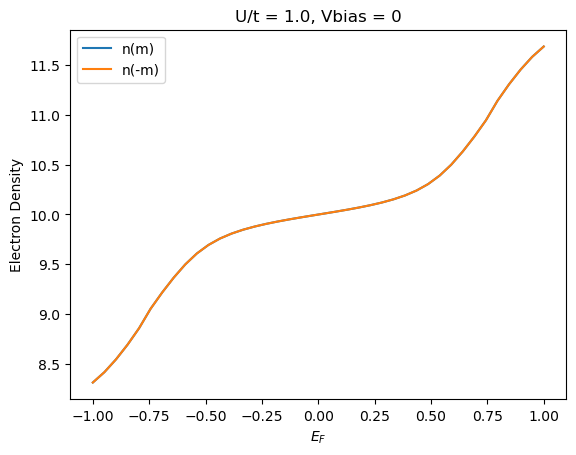

In [46]:
plt.title('U/t = {}, Vbias = 0'.format(U/t))
plt.plot(eflist_adj,nPlist_total,label = 'n(m)')
plt.plot(eflist_adj,nMlist_total,label = 'n(-m)')
plt.xlabel('$E_F$')
plt.ylabel('Electron Density')
plt.legend()
plt.show()

In [70]:

def func_ef_var(Hamiltonian0,delta_n,
                nPlist_total,eflist_adj):

    deltan = 0.3
    dim = Hamiltonian0.shape[0]
    ne_half = dim/2
    nemax = ne_half + abs(deltan)
    nemin = ne_half - abs(deltan)

    ef_target_list = []


    for k in range(len(eflist_adj)):

        nek = nPlist_total[k]

        if nek <= nemax and nek >= nemin:
            ef_target_list.append(eflist_adj[k])
    return ef_target_list  

In [71]:
ef_target_list = func_ef_var(Hamiltonian0,0.3,
                nPlist_total,eflist_adj)

In [73]:
print(ef_target_list)

[-0.4358974358974359, -0.3846153846153846, -0.33333333333333337, -0.28205128205128205, -0.23076923076923084, -0.17948717948717952, -0.1282051282051282, -0.07692307692307698, -0.02564102564102566, 0.02564102564102555, 0.07692307692307687, 0.1282051282051282, 0.17948717948717952, 0.23076923076923084, 0.28205128205128194, 0.33333333333333326, 0.3846153846153846, 0.4358974358974359]


In [75]:
len(ef_target_list)

18